# 手势识别
### 手势识别是Ng课程中常用到的例子，我们试图用
#### 1、tf2（NN）
#### 2、tf.keras（NN）
#### 3、CNN 
#### 4、ResNet
### 分别实现

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import matplotlib.image as mpimg   # mpimg 用于读取图片
import os
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import  ZeroPadding2D,AveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
import h5py

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
def initialize_parameters(layers_dims):
    """
    初始化多层网络参数W，b
   
   输入：
        layers_dims - 列表：包含网络中每层的节点数量
        init - 初始化方案，有"usual"和"random"两种
        rdnum - 初始化乘数
        init_seed - 初始化随机因子
    
    输出：
        parameters - 字典变量，包含参数“W1”，“b1”，...，“WL”，“bL”的字典：
                     Wl - np数组，权重矩阵，维度为（layers_dims [l]，layers_dims [l-1]）
                     bl - np数组，偏向量，维度为（layers_dims [l]，1）
    """
    parameters = {}
    L = len(layers_dims)


    for l in range(1,L):
        parameters["W" + str(l)] = tf.Variable(tf.random.truncated_normal([layers_dims[l-1],layers_dims[l]], stddev=0.1))
        parameters["b" + str(l)] = tf.Variable(tf.random.truncated_normal([layers_dims[l]], stddev=0.1))
       
        
    return parameters

## 加载数据

X_train.shape: (1080, 12288)
Y_train.shape: (1080, 1)
X_test.shape: (120, 12288)
Y_test.shape: (120, 1)


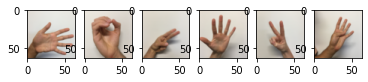

In [4]:
X_train_orig , Y_train , X_test_orig , Y_test , classes = load_dataset()
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0],-1) #每一列就是一个样本
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0],-1)

#归一化数据
X_train = X_train_flatten / 255
X_test = X_test_flatten / 255
Y_train =Y_train.T
Y_test = Y_test.T

print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#plt.rcParams['figure.figsize'] = (40.0, 40.0)
for index in range(6):
    plt.subplot(1, 6, index + 1)
    plt.imshow(X_train_orig[index])

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
X_train = tf.cast(X_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)
Y_train = np.squeeze(Y_train)
Y_test = np.squeeze(Y_test)
total_number_train = X_train.shape[0]
total_number_test = X_test.shape[0]

# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(32)
m = X_train.shape[0]
minibatch_num = int(m/32)+1

## 1、tf2（NN）—— sgd

epoch: 0 loss: 1.9281428280998678
Train_acc: 0.17777777777777778
Test_acc: 0.15833333333333333
--------------------------
epoch: 100 loss: 1.7821074198274052
Train_acc: 0.20462962962962963
Test_acc: 0.18333333333333332
--------------------------
epoch: 200 loss: 1.7644091038142933
Train_acc: 0.26296296296296295
Test_acc: 0.23333333333333334
--------------------------
epoch: 300 loss: 1.7484222299912398
Train_acc: 0.2953703703703704
Test_acc: 0.2833333333333333
--------------------------
epoch: 400 loss: 1.7293727923842037
Train_acc: 0.30185185185185187
Test_acc: 0.26666666666666666
--------------------------


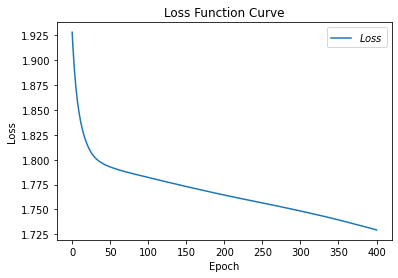

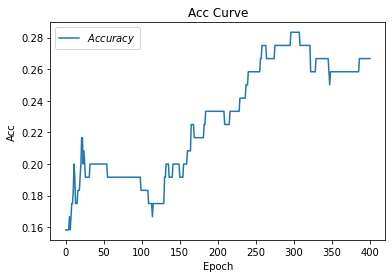

In [5]:
layers_dims = [12288,25,12,6]
parameters = initialize_parameters(layers_dims)

lr = 0.0001  
train_loss_results = []  
test_acc = []  # 
epoch = 401 # 
loss_all = 0  # 


# 训练部分
for epoch in range(epoch):  #数据集级别的循环，每个epoch循环一次数据集
    total_correct = 0
    for step, (X_train, Y_train) in enumerate(train_db):  #batch级别的循环 ，每个step循环一个batch
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            #前向传播
            #第一层
            Z1 = tf.matmul(X_train, parameters["W1"]) + parameters["b1"]  # 神经网络乘加运算
            A1 = tf.nn.relu(Z1)
            #第二层
            Z2 = tf.matmul(A1, parameters["W2"]) + parameters["b2"]
            A2 = tf.nn.relu(Z2)
            #第三层
            y = tf.matmul(A2, parameters["W3"]) + parameters["b3"] 
            y = tf.nn.softmax(y) 
            
            y_ = tf.one_hot(Y_train, depth=6)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            #损失函数
            #loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss = tf.reduce_mean(tf.losses.categorical_crossentropy(y_,y))
        loss_all += loss.numpy()  
        # 计算loss对各个参数的梯度
        variables = [parameters["W1"], parameters["b1"], parameters["W2"],
                     parameters["b2"],parameters["W3"],parameters["b3"]]
        grads = tape.gradient(loss, variables)
        #更新参数
        parameters["W1"].assign_sub(lr * grads[0])
        parameters["b1"].assign_sub(lr * grads[1])
        parameters["W2"].assign_sub(lr * grads[2])
        parameters["b2"].assign_sub(lr * grads[3])
        parameters["W3"].assign_sub(lr * grads[4])
        parameters["b3"].assign_sub(lr * grads[5])
        #预测训良集的准确率
        pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
        pred = tf.cast(pred, dtype=Y_train.dtype)
        correct = tf.cast(tf.equal(pred, Y_train), dtype=tf.int32)
        correct = tf.reduce_sum(correct)
        total_correct += int(correct)  
        acc_train = total_correct / total_number_train
    acc = total_correct / total_number_test
    if epoch % 100 == 0:
        print('epoch:', epoch, 'loss:', loss_all/minibatch_num)
        print("Train_acc:", acc_train)
    train_loss_results.append(loss_all / minibatch_num) 
    loss_all = 0
#分批测试
    total_correct = 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        Z1 = tf.matmul(x_test, parameters["W1"]) + parameters["b1"]  # 神经网络乘加运算
        A1 = tf.nn.relu(Z1)
            
        Z2 = tf.matmul(A1, parameters["W2"]) + parameters["b2"]
        A2 = tf.nn.relu(Z2)
            
        y = tf.matmul(A2, parameters["W3"]) + parameters["b3"] 
        y = tf.nn.softmax(y) 
        pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
       
        pred = tf.cast(pred, dtype=y_test.dtype)
        
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
       
        correct = tf.reduce_sum(correct)
       
        total_correct += int(correct)  
    acc_test = total_correct / total_number_test
    test_acc.append(acc_test)
    if epoch % 100 == 0:
        print("Test_acc:", acc_test)
        print("--------------------------")  
# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()

## 1、tf2（NN）—— adam
### 用sgd更性法效果很不好，换成adam优化器

In [6]:
def initialize_adam(parameters):
    """
    adam初始化中间变量v , s

    输入：
        parameters - 字典变量，来自def initialize_parameters()的返回值
    输出：
        v - 字典变量，包含梯度的指数加权平均值
        s - 字典变量，包含平方梯度的指数加权平均值
    
    """
    
    L = len(parameters) // 2
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
        
        s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
    
    return v,s

In [7]:
def updata_parameters_adam(parameters,grads,v,s,t,lr,beta1=0.9,beta2=0.999,epsilon=1e-8):
    """
    Adam更新参数
    
    输入：
        parameters - 经过学习训练后的参数
        grads -  包含梯度值的字典，由def model_backward()获得
        lr - 学习率
        v - 经过学习训练后的v参数
        s - Adam的中间变量，平方梯度的移动平均值
        t - 当前迭代的次数
        lr - 学习率
        beta1 - 超参数，修正偏差
        beta2 - RMSprop的超参数
        epsilon - 防止除零操作
    
    输出：
        parameters - 更新后的参数
        v - 经过学习训练后的v参数
        s - 经过学习训练后的s参数
    """
    L = len(parameters) // 2
    v_corrected = {} #偏差修正后的值
    s_corrected = {} #偏差修正后的值
    
    for l in range(L):
        
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads[2*l]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads[2*l + 1]
        
        # v的偏差修正
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1,t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1,t))
    
        
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.square(grads[2*l])
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.square(grads[2*l + 1])
         
        # s的偏差修正
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2,t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2,t))
        
        #更新参数
        parameters["W" + str(l + 1)].assign_sub(lr *  (v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + epsilon)))
        parameters["b" + str(l + 1)].assign_sub(lr * (v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + epsilon)))

        return parameters,v,s

epoch: 0 loss: 1.8017517713939442
Train_acc: 0.18518518518518517
Test_acc: 0.25
--------------------------
epoch: 100 loss: 1.3049228752360624
Train_acc: 0.5083333333333333
Test_acc: 0.4583333333333333
--------------------------
epoch: 200 loss: 1.1492164906333475
Train_acc: 0.5824074074074074
Test_acc: 0.5333333333333333
--------------------------
epoch: 300 loss: 1.0524439110475428
Train_acc: 0.6259259259259259
Test_acc: 0.5833333333333334
--------------------------
epoch: 400 loss: 0.9839921961812412
Train_acc: 0.6620370370370371
Test_acc: 0.6083333333333333
--------------------------


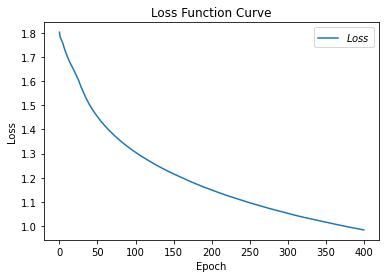

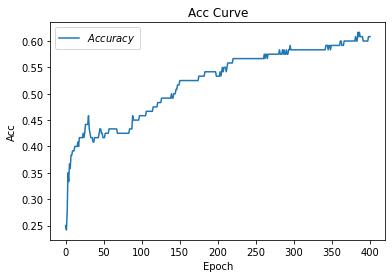

In [8]:
X_train_orig , Y_train , X_test_orig , Y_test , classes = load_dataset()
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0],-1) #每一列就是一个样本
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0],-1)

#归一化数据
X_train = X_train_flatten / 255
X_test = X_test_flatten / 255
Y_train =Y_train.T
Y_test = Y_test.T

# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
X_train = tf.cast(X_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)
Y_train = np.squeeze(Y_train)
Y_test = np.squeeze(Y_test)
total_number_train = X_train.shape[0]
total_number_test = X_test.shape[0]

# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(32)
m = X_train.shape[0]
minibatch_num = int(m/32)+1


layers_dims = [12288,25,12,6]
parameters = initialize_parameters(layers_dims)

lr = 0.0001  # 学习率为0.1
train_loss_results = []  # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = []  # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 401 # 循环500轮
loss_all = 0  # 每轮分4个step，loss_all记录四个step生成的4个loss的和
t = 0
##########################################################################
v,s = initialize_adam(parameters)
beta1=0.9
beta2=0.999
epsilon=1e-8
##########################################################################

# 训练部分
for epoch in range(epoch):  #数据集级别的循环，每个epoch循环一次数据集
    total_correct = 0
    for step, (X_train, Y_train) in enumerate(train_db):  #batch级别的循环 ，每个step循环一个batch
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            t = t+1
            Z1 = tf.matmul(X_train, parameters["W1"]) + parameters["b1"]  # 神经网络乘加运算
            A1 = tf.nn.relu(Z1)
            
            Z2 = tf.matmul(A1, parameters["W2"]) + parameters["b2"]
            A2 = tf.nn.relu(Z2)
            
            y = tf.matmul(A2, parameters["W3"]) + parameters["b3"] 
            y = tf.nn.softmax(y) 
            
            y_ = tf.one_hot(Y_train, depth=6)  # 将标签值转换为独热码格式，方便计算loss和accuracy
          
            #loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss = tf.reduce_mean(tf.losses.categorical_crossentropy(y_,y))
        loss_all += loss.numpy()  
        # 计算loss对各个参数的梯度
        variables = [parameters["W1"], parameters["b1"], parameters["W2"],
                     parameters["b2"],parameters["W3"],parameters["b3"]]
        grads = tape.gradient(loss, variables)
  
        #更新参数
        parameters,v,s =  updata_parameters_adam(parameters,grads,v,s,t,lr,beta1,beta2,epsilon)
        
        
        pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
        pred = tf.cast(pred, dtype=Y_train.dtype)
        correct = tf.cast(tf.equal(pred, Y_train), dtype=tf.int32)
        correct = tf.reduce_sum(correct)
        total_correct += int(correct)
    acc_train = total_correct / total_number_train
    if epoch % 100 == 0:
        print('epoch:', epoch, 'loss:', loss_all/minibatch_num)
        print("Train_acc:", acc_train)
    train_loss_results.append(loss_all / minibatch_num)
    loss_all = 0
#分批测试
    total_correct = 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        Z1 = tf.matmul(x_test, parameters["W1"]) + parameters["b1"]  # 神经网络乘加运算
        A1 = tf.nn.relu(Z1)
            
        Z2 = tf.matmul(A1, parameters["W2"]) + parameters["b2"]
        A2 = tf.nn.relu(Z2)
            
        y = tf.matmul(A2, parameters["W3"]) + parameters["b3"] 
        y = tf.nn.softmax(y) 
        pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
        pred = tf.cast(pred, dtype=y_test.dtype)
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        correct = tf.reduce_sum(correct)
        total_correct += int(correct)
        # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数

# 总体测试    
#    Z1 = tf.matmul(X_test, parameters["W1"]) + parameters["b1"]  # 神经网络乘加运算
#    A1 = tf.nn.relu(Z1)
#            
#    Z2 = tf.matmul(A1, parameters["W2"]) + parameters["b2"]
#    A2 = tf.nn.relu(Z2)
#            
#    y = tf.matmul(A2, parameters["W3"]) + parameters["b3"] 
#    y = tf.nn.softmax(y) 
#    pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
#    # 将pred转换为y_test的数据类型
#    pred = tf.cast(pred, dtype=Y_test.dtype)
#    # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
#    correct = tf.cast(tf.equal(pred, Y_test), dtype=tf.int32)
#    # 将每个batch的correct数加起来
#    correct = tf.reduce_sum(correct)
#    # 将所有batch中的correct数加起来
#    total_correct = int(correct)
#    # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
#    total_number = X_test.shape[0]    
    acc_test = total_correct / total_number_test
    test_acc.append(acc_test)
    if epoch % 100 == 0:
        print("Test_acc:", acc_test)
        print("--------------------------")
        
# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()

## 测试一下

In [11]:
def predict(index,parameters):
    ##测试自己的图片
#    fileName = "datasets/fingers/" + image_name
#my_image = image.load_img(fileName, target_size=(64, 64))
#my_image = image.img_to_array(my_image)
#my_image = my_image/ 255
#plt.imshow(my_image)
#my_image = np.expand_dims(my_image,axis=0)
#my_image = my_image.reshape(1,64 * 64 * 3) 
    my_image = np.expand_dims(X_test[index],axis=0)

    Z1 = tf.matmul(my_image, parameters["W1"]) + parameters["b1"]  
    A1 = tf.nn.relu(Z1)
    Z2 = tf.matmul(A1, parameters["W2"]) + parameters["b2"]
    A2 = tf.nn.relu(Z2)
            
    y = tf.matmul(A2, parameters["W3"]) + parameters["b3"] 
    y = tf.nn.softmax(y) 
    pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
    
    print("the number is ",pred.numpy())

input the number of test images:3
the index of test picture:45


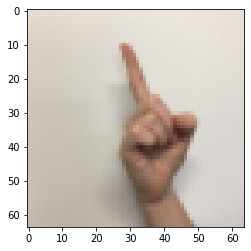

the number is  [1]
the index of test picture:21


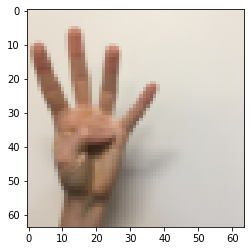

the number is  [4]
the index of test picture:78


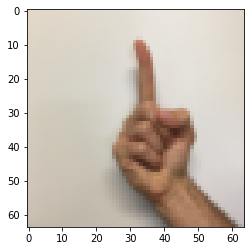

the number is  [1]


In [13]:
preNum = int(input("input the number of test images:"))
for i in range(preNum):
    index = input("the index of test picture:")
    index = int(index)
    plt.imshow(X_test_orig[index])
    plt.show()
    predict(index,parameters)

# 2、keras（NN）

Epoch 1/600
34/34 - 0s - loss: 1.8141 - sparse_categorical_accuracy: 0.1806 - val_loss: 1.8087 - val_sparse_categorical_accuracy: 0.1667
Epoch 2/600
34/34 - 0s - loss: 1.7778 - sparse_categorical_accuracy: 0.2000 - val_loss: 1.8156 - val_sparse_categorical_accuracy: 0.1500
Epoch 3/600
34/34 - 0s - loss: 1.7271 - sparse_categorical_accuracy: 0.2537 - val_loss: 1.7224 - val_sparse_categorical_accuracy: 0.1917
Epoch 4/600
34/34 - 0s - loss: 1.7021 - sparse_categorical_accuracy: 0.2667 - val_loss: 1.7361 - val_sparse_categorical_accuracy: 0.1917
Epoch 5/600
34/34 - 0s - loss: 1.6679 - sparse_categorical_accuracy: 0.2963 - val_loss: 1.6312 - val_sparse_categorical_accuracy: 0.3250
Epoch 6/600
34/34 - 0s - loss: 1.6357 - sparse_categorical_accuracy: 0.2935 - val_loss: 1.6314 - val_sparse_categorical_accuracy: 0.3083
Epoch 7/600
34/34 - 0s - loss: 1.6058 - sparse_categorical_accuracy: 0.3204 - val_loss: 1.5921 - val_sparse_categorical_accuracy: 0.3417
Epoch 8/600
34/34 - 0s - loss: 1.5637 - s

Epoch 61/600
34/34 - 0s - loss: 0.8948 - sparse_categorical_accuracy: 0.7019 - val_loss: 0.9576 - val_sparse_categorical_accuracy: 0.6917
Epoch 62/600
34/34 - 0s - loss: 0.8787 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.9342 - val_sparse_categorical_accuracy: 0.6917
Epoch 63/600
34/34 - 0s - loss: 0.8712 - sparse_categorical_accuracy: 0.7194 - val_loss: 0.9341 - val_sparse_categorical_accuracy: 0.6917
Epoch 64/600
34/34 - 0s - loss: 0.8650 - sparse_categorical_accuracy: 0.7083 - val_loss: 0.9236 - val_sparse_categorical_accuracy: 0.7000
Epoch 65/600
34/34 - 0s - loss: 0.8573 - sparse_categorical_accuracy: 0.7204 - val_loss: 0.9224 - val_sparse_categorical_accuracy: 0.6667
Epoch 66/600
34/34 - 0s - loss: 0.8500 - sparse_categorical_accuracy: 0.7398 - val_loss: 0.9591 - val_sparse_categorical_accuracy: 0.6667
Epoch 67/600
34/34 - 0s - loss: 0.8432 - sparse_categorical_accuracy: 0.7287 - val_loss: 0.9111 - val_sparse_categorical_accuracy: 0.6917
Epoch 68/600
34/34 - 0s - loss: 0.

Epoch 121/600
34/34 - 0s - loss: 0.6018 - sparse_categorical_accuracy: 0.8269 - val_loss: 0.7147 - val_sparse_categorical_accuracy: 0.7917
Epoch 122/600
34/34 - 0s - loss: 0.5984 - sparse_categorical_accuracy: 0.8241 - val_loss: 0.7184 - val_sparse_categorical_accuracy: 0.7583
Epoch 123/600
34/34 - 0s - loss: 0.6037 - sparse_categorical_accuracy: 0.8176 - val_loss: 0.7281 - val_sparse_categorical_accuracy: 0.7250
Epoch 124/600
34/34 - 0s - loss: 0.5912 - sparse_categorical_accuracy: 0.8287 - val_loss: 0.7124 - val_sparse_categorical_accuracy: 0.7667
Epoch 125/600
34/34 - 0s - loss: 0.5831 - sparse_categorical_accuracy: 0.8306 - val_loss: 0.7283 - val_sparse_categorical_accuracy: 0.7083
Epoch 126/600
34/34 - 0s - loss: 0.5884 - sparse_categorical_accuracy: 0.8269 - val_loss: 0.6978 - val_sparse_categorical_accuracy: 0.7917
Epoch 127/600
34/34 - 0s - loss: 0.5850 - sparse_categorical_accuracy: 0.8296 - val_loss: 0.7079 - val_sparse_categorical_accuracy: 0.7417
Epoch 128/600
34/34 - 0s - 

Epoch 180/600
34/34 - 0s - loss: 0.4591 - sparse_categorical_accuracy: 0.8787 - val_loss: 0.6219 - val_sparse_categorical_accuracy: 0.8000
Epoch 181/600
34/34 - 0s - loss: 0.4611 - sparse_categorical_accuracy: 0.8769 - val_loss: 0.6836 - val_sparse_categorical_accuracy: 0.7500
Epoch 182/600
34/34 - 0s - loss: 0.4771 - sparse_categorical_accuracy: 0.8556 - val_loss: 0.6333 - val_sparse_categorical_accuracy: 0.7583
Epoch 183/600
34/34 - 0s - loss: 0.4580 - sparse_categorical_accuracy: 0.8667 - val_loss: 0.6187 - val_sparse_categorical_accuracy: 0.7833
Epoch 184/600
34/34 - 0s - loss: 0.4601 - sparse_categorical_accuracy: 0.8676 - val_loss: 0.6304 - val_sparse_categorical_accuracy: 0.7750
Epoch 185/600
34/34 - 0s - loss: 0.4478 - sparse_categorical_accuracy: 0.8852 - val_loss: 0.6099 - val_sparse_categorical_accuracy: 0.7583
Epoch 186/600
34/34 - 0s - loss: 0.4461 - sparse_categorical_accuracy: 0.8824 - val_loss: 0.6114 - val_sparse_categorical_accuracy: 0.7917
Epoch 187/600
34/34 - 0s - 

Epoch 239/600
34/34 - 0s - loss: 0.3543 - sparse_categorical_accuracy: 0.9102 - val_loss: 0.5533 - val_sparse_categorical_accuracy: 0.8000
Epoch 240/600
34/34 - 0s - loss: 0.3525 - sparse_categorical_accuracy: 0.9111 - val_loss: 0.5710 - val_sparse_categorical_accuracy: 0.8000
Epoch 241/600
34/34 - 0s - loss: 0.3627 - sparse_categorical_accuracy: 0.9019 - val_loss: 0.5517 - val_sparse_categorical_accuracy: 0.7833
Epoch 242/600
34/34 - 0s - loss: 0.3599 - sparse_categorical_accuracy: 0.9028 - val_loss: 0.6033 - val_sparse_categorical_accuracy: 0.7583
Epoch 243/600
34/34 - 0s - loss: 0.3583 - sparse_categorical_accuracy: 0.9009 - val_loss: 0.5593 - val_sparse_categorical_accuracy: 0.7917
Epoch 244/600
34/34 - 0s - loss: 0.3629 - sparse_categorical_accuracy: 0.9000 - val_loss: 0.5623 - val_sparse_categorical_accuracy: 0.8250
Epoch 245/600
34/34 - 0s - loss: 0.3510 - sparse_categorical_accuracy: 0.9074 - val_loss: 0.5552 - val_sparse_categorical_accuracy: 0.8083
Epoch 246/600
34/34 - 0s - 

Epoch 298/600
34/34 - 0s - loss: 0.2789 - sparse_categorical_accuracy: 0.9370 - val_loss: 0.5388 - val_sparse_categorical_accuracy: 0.8000
Epoch 299/600
34/34 - 0s - loss: 0.2783 - sparse_categorical_accuracy: 0.9333 - val_loss: 0.5183 - val_sparse_categorical_accuracy: 0.8083
Epoch 300/600
34/34 - 0s - loss: 0.2787 - sparse_categorical_accuracy: 0.9370 - val_loss: 0.5181 - val_sparse_categorical_accuracy: 0.8333
Epoch 301/600
34/34 - 0s - loss: 0.2718 - sparse_categorical_accuracy: 0.9370 - val_loss: 0.5151 - val_sparse_categorical_accuracy: 0.8333
Epoch 302/600
34/34 - 0s - loss: 0.2747 - sparse_categorical_accuracy: 0.9361 - val_loss: 0.5089 - val_sparse_categorical_accuracy: 0.8083
Epoch 303/600
34/34 - 0s - loss: 0.2742 - sparse_categorical_accuracy: 0.9306 - val_loss: 0.5258 - val_sparse_categorical_accuracy: 0.8250
Epoch 304/600
34/34 - 0s - loss: 0.2740 - sparse_categorical_accuracy: 0.9380 - val_loss: 0.5220 - val_sparse_categorical_accuracy: 0.8083
Epoch 305/600
34/34 - 0s - 

Epoch 357/600
34/34 - 0s - loss: 0.2201 - sparse_categorical_accuracy: 0.9556 - val_loss: 0.5025 - val_sparse_categorical_accuracy: 0.8167
Epoch 358/600
34/34 - 0s - loss: 0.2157 - sparse_categorical_accuracy: 0.9602 - val_loss: 0.5268 - val_sparse_categorical_accuracy: 0.8167
Epoch 359/600
34/34 - 0s - loss: 0.2185 - sparse_categorical_accuracy: 0.9602 - val_loss: 0.5305 - val_sparse_categorical_accuracy: 0.7917
Epoch 360/600
34/34 - 0s - loss: 0.2260 - sparse_categorical_accuracy: 0.9500 - val_loss: 0.4920 - val_sparse_categorical_accuracy: 0.8500
Epoch 361/600
34/34 - 0s - loss: 0.2162 - sparse_categorical_accuracy: 0.9583 - val_loss: 0.4990 - val_sparse_categorical_accuracy: 0.7917
Epoch 362/600
34/34 - 0s - loss: 0.2141 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.4782 - val_sparse_categorical_accuracy: 0.8667
Epoch 363/600
34/34 - 0s - loss: 0.2067 - sparse_categorical_accuracy: 0.9602 - val_loss: 0.4903 - val_sparse_categorical_accuracy: 0.8167
Epoch 364/600
34/34 - 0s - 

Epoch 416/600
34/34 - 0s - loss: 0.1785 - sparse_categorical_accuracy: 0.9657 - val_loss: 0.4879 - val_sparse_categorical_accuracy: 0.8583
Epoch 417/600
34/34 - 0s - loss: 0.1707 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.4666 - val_sparse_categorical_accuracy: 0.8333
Epoch 418/600
34/34 - 0s - loss: 0.1644 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.4662 - val_sparse_categorical_accuracy: 0.8333
Epoch 419/600
34/34 - 0s - loss: 0.1700 - sparse_categorical_accuracy: 0.9713 - val_loss: 0.4871 - val_sparse_categorical_accuracy: 0.8083
Epoch 420/600
34/34 - 0s - loss: 0.1620 - sparse_categorical_accuracy: 0.9750 - val_loss: 0.4640 - val_sparse_categorical_accuracy: 0.8500
Epoch 421/600
34/34 - 0s - loss: 0.1566 - sparse_categorical_accuracy: 0.9824 - val_loss: 0.4807 - val_sparse_categorical_accuracy: 0.8083
Epoch 422/600
34/34 - 0s - loss: 0.1629 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.4693 - val_sparse_categorical_accuracy: 0.8333
Epoch 423/600
34/34 - 0s - 

Epoch 475/600
34/34 - 0s - loss: 0.1298 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.4713 - val_sparse_categorical_accuracy: 0.8333
Epoch 476/600
34/34 - 0s - loss: 0.1244 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.4648 - val_sparse_categorical_accuracy: 0.8333
Epoch 477/600
34/34 - 0s - loss: 0.1252 - sparse_categorical_accuracy: 0.9843 - val_loss: 0.4949 - val_sparse_categorical_accuracy: 0.8500
Epoch 478/600
34/34 - 0s - loss: 0.1235 - sparse_categorical_accuracy: 0.9843 - val_loss: 0.4578 - val_sparse_categorical_accuracy: 0.8583
Epoch 479/600
34/34 - 0s - loss: 0.1301 - sparse_categorical_accuracy: 0.9787 - val_loss: 0.4904 - val_sparse_categorical_accuracy: 0.8167
Epoch 480/600
34/34 - 0s - loss: 0.1216 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.4724 - val_sparse_categorical_accuracy: 0.8583
Epoch 481/600
34/34 - 0s - loss: 0.1248 - sparse_categorical_accuracy: 0.9824 - val_loss: 0.4684 - val_sparse_categorical_accuracy: 0.8750
Epoch 482/600
34/34 - 0s - 

Epoch 534/600
34/34 - 0s - loss: 0.0897 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.4640 - val_sparse_categorical_accuracy: 0.8583
Epoch 535/600
34/34 - 0s - loss: 0.0991 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.4584 - val_sparse_categorical_accuracy: 0.8667
Epoch 536/600
34/34 - 0s - loss: 0.0890 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.4595 - val_sparse_categorical_accuracy: 0.8667
Epoch 537/600
34/34 - 0s - loss: 0.1018 - sparse_categorical_accuracy: 0.9861 - val_loss: 0.4660 - val_sparse_categorical_accuracy: 0.8583
Epoch 538/600
34/34 - 0s - loss: 0.1010 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.4694 - val_sparse_categorical_accuracy: 0.8583
Epoch 539/600
34/34 - 0s - loss: 0.0905 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.4755 - val_sparse_categorical_accuracy: 0.8583
Epoch 540/600
34/34 - 0s - loss: 0.0915 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.4583 - val_sparse_categorical_accuracy: 0.8500
Epoch 541/600
34/34 - 0s - 

Epoch 593/600
34/34 - 0s - loss: 0.0641 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.4729 - val_sparse_categorical_accuracy: 0.8500
Epoch 594/600
34/34 - 0s - loss: 0.0715 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.4822 - val_sparse_categorical_accuracy: 0.8583
Epoch 595/600
34/34 - 0s - loss: 0.0678 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.4543 - val_sparse_categorical_accuracy: 0.8500
Epoch 596/600
34/34 - 0s - loss: 0.0656 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.4717 - val_sparse_categorical_accuracy: 0.8750
Epoch 597/600
34/34 - 0s - loss: 0.0670 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.4562 - val_sparse_categorical_accuracy: 0.8583
Epoch 598/600
34/34 - 0s - loss: 0.0673 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.4929 - val_sparse_categorical_accuracy: 0.8667
Epoch 599/600
34/34 - 0s - loss: 0.0741 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.5096 - val_sparse_categorical_accuracy: 0.8500
Epoch 600/600
34/34 - 0s - 

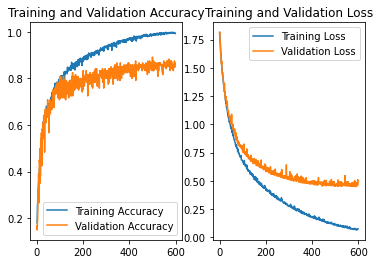

In [16]:
X_train_orig , Y_train , X_test_orig , Y_test , classes = load_dataset()

#归一化数据
X_train = X_train_orig / 255
X_test = X_test_orig / 255
Y_train =Y_train.T
Y_test = Y_test.T

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),                       #reduction='none'
              metrics=['sparse_categorical_accuracy'])


history = model.fit(X_train, Y_train, batch_size=32, epochs=600, validation_data=(X_test, Y_test), validation_freq=1,verbose=2)

model.summary()

# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 3、CNN

In [17]:
class gesture(Model):
    def __init__(self):
        super(gesture, self).__init__()
        self.c1 = Conv2D(filters=8, kernel_size=(4, 4), padding='same')  # 卷积层
        #self.b1 = BatchNormalization()  # BN层
        self.a1 = Activation('relu')  # 激活层
        self.p1 = MaxPool2D(pool_size=(8, 8), strides=8, padding='same')  # 池化层
        

        self.c2 = Conv2D(filters=16, kernel_size=(2, 2), padding='same')  # 卷积层
        #self.b1 = BatchNormalization()  # BN层
        self.a2 = Activation('relu')  # 激活层
        self.p2 = MaxPool2D(pool_size=(4, 4), strides=4, padding='same')  # 池化层
        
        
        self.flatten = Flatten()
        self.f1 = Dense(6, activation='softmax')


    def call(self, x):
        x = self.c1(x)
        x = self.a1(x)
        x = self.p1(x)
        
        x = self.c2(x)
        x = self.a2(x)
        x = self.p2(x)

        x = self.flatten(x)
        y = self.f1(x)
        return y

In [18]:
X_train_orig , Y_train , X_test_orig , Y_test , classes = load_dataset()

#归一化数据
X_train = X_train_orig / 255
X_test = X_test_orig / 255
Y_train =Y_train.T
Y_test = Y_test.T

Epoch 1/150
17/17 - 1s - loss: 1.7983 - sparse_categorical_accuracy: 0.1630 - val_loss: 1.7926 - val_sparse_categorical_accuracy: 0.1667
Epoch 2/150
17/17 - 1s - loss: 1.7911 - sparse_categorical_accuracy: 0.1806 - val_loss: 1.7841 - val_sparse_categorical_accuracy: 0.2750
Epoch 3/150
17/17 - 1s - loss: 1.7840 - sparse_categorical_accuracy: 0.1981 - val_loss: 1.7744 - val_sparse_categorical_accuracy: 0.2750
Epoch 4/150
17/17 - 1s - loss: 1.7606 - sparse_categorical_accuracy: 0.2741 - val_loss: 1.7347 - val_sparse_categorical_accuracy: 0.3333
Epoch 5/150
17/17 - 1s - loss: 1.7024 - sparse_categorical_accuracy: 0.3185 - val_loss: 1.6518 - val_sparse_categorical_accuracy: 0.3417
Epoch 6/150
17/17 - 1s - loss: 1.5879 - sparse_categorical_accuracy: 0.3833 - val_loss: 1.5443 - val_sparse_categorical_accuracy: 0.4167
Epoch 7/150
17/17 - 1s - loss: 1.4932 - sparse_categorical_accuracy: 0.4269 - val_loss: 1.4743 - val_sparse_categorical_accuracy: 0.4083
Epoch 8/150
17/17 - 1s - loss: 1.3737 - s

Epoch 61/150
17/17 - 1s - loss: 0.2107 - sparse_categorical_accuracy: 0.9315 - val_loss: 0.5257 - val_sparse_categorical_accuracy: 0.8333
Epoch 62/150
17/17 - 1s - loss: 0.1969 - sparse_categorical_accuracy: 0.9287 - val_loss: 0.4792 - val_sparse_categorical_accuracy: 0.8583
Epoch 63/150
17/17 - 1s - loss: 0.2064 - sparse_categorical_accuracy: 0.9250 - val_loss: 0.4866 - val_sparse_categorical_accuracy: 0.8500
Epoch 64/150
17/17 - 1s - loss: 0.1984 - sparse_categorical_accuracy: 0.9380 - val_loss: 0.4442 - val_sparse_categorical_accuracy: 0.8500
Epoch 65/150
17/17 - 1s - loss: 0.2134 - sparse_categorical_accuracy: 0.9222 - val_loss: 0.5103 - val_sparse_categorical_accuracy: 0.8083
Epoch 66/150
17/17 - 1s - loss: 0.1893 - sparse_categorical_accuracy: 0.9343 - val_loss: 0.4659 - val_sparse_categorical_accuracy: 0.8500
Epoch 67/150
17/17 - 1s - loss: 0.1902 - sparse_categorical_accuracy: 0.9352 - val_loss: 0.5468 - val_sparse_categorical_accuracy: 0.8250
Epoch 68/150
17/17 - 1s - loss: 0.

Epoch 121/150
17/17 - 1s - loss: 0.1017 - sparse_categorical_accuracy: 0.9676 - val_loss: 0.4795 - val_sparse_categorical_accuracy: 0.8583
Epoch 122/150
17/17 - 1s - loss: 0.1024 - sparse_categorical_accuracy: 0.9657 - val_loss: 0.5388 - val_sparse_categorical_accuracy: 0.8417
Epoch 123/150
17/17 - 1s - loss: 0.1098 - sparse_categorical_accuracy: 0.9639 - val_loss: 0.4792 - val_sparse_categorical_accuracy: 0.8417
Epoch 124/150
17/17 - 1s - loss: 0.0871 - sparse_categorical_accuracy: 0.9759 - val_loss: 0.4854 - val_sparse_categorical_accuracy: 0.8500
Epoch 125/150
17/17 - 1s - loss: 0.1088 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.5490 - val_sparse_categorical_accuracy: 0.8250
Epoch 126/150
17/17 - 1s - loss: 0.1014 - sparse_categorical_accuracy: 0.9630 - val_loss: 0.5617 - val_sparse_categorical_accuracy: 0.8000
Epoch 127/150
17/17 - 1s - loss: 0.0946 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.5044 - val_sparse_categorical_accuracy: 0.8417
Epoch 128/150
17/17 - 1s - 

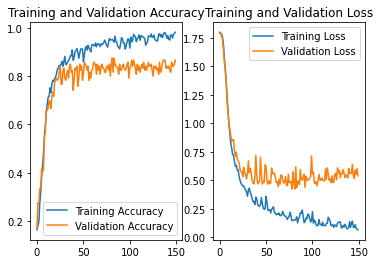

In [19]:
model = gesture()

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.009),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(X_train, Y_train, batch_size=64, epochs=150, validation_data=(X_test, Y_test), validation_freq=1,verbose=2)

model.summary()

# 显示训练集和验证集的acc和loss曲线
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 4、ResNet

In [20]:
class ResnetBlock(Model):

    def __init__(self, f,filters, strides=1, residual_path=False):
        super(ResnetBlock, self).__init__()
        self.filters = filters
        self.strides = strides
        self.residual_path = residual_path
        self.c1 = Conv2D(filters[0], (1, 1), strides=strides, padding='valid')
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')

        self.c2 = Conv2D(filters[1], (f, f), strides=1, padding='same')
        self.b2 = BatchNormalization()
        self.a2 = Activation('relu')
            
        self.c3 = Conv2D(filters[2], (1, 1), strides=1, padding='valid')
        self.b3 = BatchNormalization()
        
        if residual_path:            
            self.down_c1 = Conv2D(filters[2], (1, 1), strides=strides, padding='valid')
            self.down_b1 = BatchNormalization()
           
        self.a3 = Activation('relu')

    def call(self, inputs):
        residual = inputs  # residual等于输入值本身，即residual=x
        # 将输入通过卷积、BN层、激活层，计算F(x)
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)
            
        x = self.c2(x)
        x = self.b2(x)
        x = self.a2(x)
        
        x = self.c3(x)
        y = self.b3(x)
            
        if self.residual_path:
            residual = self.down_c1(inputs)
            residual = self.down_b1(residual)          

        out = self.a3(y + residual) 
        
        return out

In [21]:
class ResNet50(Model):

    def __init__(self):  # block_list表示每个block有几个卷积层
        super(ResNet50, self).__init__()

        #stage1
        self.zp1 = ZeroPadding2D(padding=(3,3))                                             
        self.c1 = Conv2D(64, (7, 7), strides=2, padding='valid')       
        self.b1 = BatchNormalization()                                             
        self.a1 = Activation('relu')                                                     
        self.mp1 = MaxPool2D(pool_size=(3,3), strides=(2,2))
        self.blocks = tf.keras.models.Sequential()
        # 构建ResNet网络结构
        #stage2
        block = ResnetBlock(f=3, filters=[64,64,256], strides=1, residual_path=True)             
        self.blocks.add(block)
        block = ResnetBlock(f=3, filters=[64,64,256])                                                                 
        self.blocks.add(block)
        block = ResnetBlock(f=3, filters=[64,64,256])                                                                
        self.blocks.add(block)
        #stage3
        block = ResnetBlock(f=3, filters=[128,128,512], strides=2, residual_path=True)         
        self.blocks.add(block)
        block = ResnetBlock(f=3, filters=[128,128,512])                                                                            
        self.blocks.add(block)
        block = ResnetBlock(f=3, filters=[128,128,512])
        self.blocks.add(block)
        block = ResnetBlock(f=3, filters=[128,128,512])
        self.blocks.add(block)
        
        #stage4
        block = ResnetBlock( f=3, filters=[256,256,1024], strides=2, residual_path=True)
        self.blocks.add(block)
        block = ResnetBlock(f=3, filters=[256,256,1024])
        self.blocks.add(block)
        block = ResnetBlock( f=3, filters=[256,256,1024])
        self.blocks.add(block)
        block = ResnetBlock(f=3, filters=[256,256,1024])
        self.blocks.add(block)
        block = ResnetBlock(f=3, filters=[256,256,1024])
        self.blocks.add(block)
        block = ResnetBlock(f=3, filters=[256,256,1024])
        self.blocks.add(block)
        
        
        #stage5
        block = ResnetBlock(f=3, filters=[512,512,2048], strides=2, residual_path=True)
        self.blocks.add(block)
        block = ResnetBlock(f=3, filters=[512,512,2048])
        self.blocks.add(block)
        block = ResnetBlock(f=3, filters=[512,512,2048])
        self.blocks.add(block)
        
        
        self.ap1 = AveragePooling2D(pool_size=(2,2),padding="same")
        self.flatten = Flatten()
        self.f1 = Dense(6, activation='softmax')

    def call(self, inputs):
        x = self.zp1(inputs)       
        x = self.c1(x)
        x = self.b1(x)
        x = self.a1(x)
        x = self.mp1(x)
        x = self.blocks(x)
        x = self.ap1(x)
        x = self.flatten (x)
        y = self.f1(x)
        return y

In [22]:
model = ResNet50()
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [23]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.
Y_train  =Y_train_orig.T
Y_test = Y_test_orig.T

### 仅仅运行2个epochs

In [24]:
model.fit(X_train,Y_train,epochs=2,batch_size=32)
model.summary()
preds = model.evaluate(X_test,Y_test)
print("误差值 = " + str(preds[0]))
print("准确率 = " + str(preds[1]))

Epoch 1/2
34/34 [==============================] - 56s 2s/step - loss: 1.8509 - sparse_categorical_accuracy: 0.4880
Epoch 2/2
34/34 [==============================] - 53s 2s/step - loss: 0.5471 - sparse_categorical_accuracy: 0.8120
Model: "res_net50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  9472      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
activation_2 (Activation)    multiple                  0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_______________________

### 加载训练好的模型
#### 上面虽然实现了ResNet，但是需要浪费大量时间，直接加载一个别人训练好的模型看看效果

In [26]:
fine_model = tf.keras.models.load_model("ResNet50.h5") 
fine_model.summary()

Y_test = np.eye(6)[Y_test_orig.reshape(-1)]

preds = fine_model.evaluate(X_test,Y_test)
print("误差值 = " + str(preds[0]))
print("准确率 = " + str(preds[1]))

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

4/4 [==============================] - 0s 124ms/step - loss: 0.1085 - accuracy: 0.9667
误差值 = 0.1085430383682251
准确率 = 0.9666666388511658


In [ ]:
preNum = int(input("input the number of test pictures:"))

for i in range(preNum):
    index = input("the index of test picture:")
    index = int(index)
    my_image = np.expand_dims(X_test[index],axis=0)
    plt.imshow(X_test[index])
    plt.show()
    result = fine_model.predict(my_image)
    pred = tf.argmax(result, axis=1)
    print(pred.numpy())